In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# plt.ioff()

import re
import os
import pandas as pd
import itertools
from itertools import permutations
from itertools import chain
from collections import Counter, defaultdict

from collections import OrderedDict

import seaborn as sns
from scipy import stats

from pymongo import MongoClient

from ut.util.imports.ipython_utils import *
from ut.util.imports.data_analysis import *
from ut.pdict.get import head


# from ut.ppi.pot import Pot
# from ut.ppi.pairs_pot import EdgeCounter, BinaryNaiveGraph


    printProgress
    numof_trues
    ppr



# Example: TestAnalyzer

In [3]:
from ut.wserv.dashboard.test_analyzer import TestAnalyzer

An Analyzer is a class to manage a simple dashboard that takes inputs from an html form, and takes action on these
inputs.

An Analyzer is defined by a list of dicts, each specifying an form input element in a way that is very similar to standard html form elements. Each dict should contain a name and a type. If the type is 'submit', the Analyzer should have a method of the same name as the 'name' key of the element. This is checked by the verify_existence_of_submit_functions() method.

Attributes:
    * input_element_collection: The underlying InputElementCollection
    * submit_method: A list of the names of the InputElements that have type='submit'
    * input: A dict containing the {key: val} pairs of the forms input values (these are set only when the
    set_inputs(**kwargs) is called.

Methods:
    The set_input(\*\*kwargs) method updates the input key values (only for those already existing keys)

    The call_submit_function(name, \*\*kwargs) updates the input key values (using set_input(\*\*kwargs)) and then calls
    the named method with the \*\*kwargs input.

#### Example: TestAnalyzer

This Analyzer is constructed with the following form elements:

    form_elements = [
        dict(name='your_name', type='text', display="Your Name", value='Unknown'),
        dict(name='max_num', type='number', value=1),
        dict(name='register', type='submit', value='register inputs'),
        dict(name='npts', type='number', value=30, display="num of rand pts"),
        dict(name='graph', type='submit', value="graph it")
    ]

In [4]:
lyzer = TestAnalyzer()
print(lyzer)  # uses the object's __str__() method (calls to_html())
lyzer  # uses the object's __repr__() method (returns the key: val pairs of the inputs)

<form>
Your Name<input type="text" name="your_name" value="Unknown">
<br>
max_num<input type="number" name="max_num" value="1">
<br>
<input type="submit" name="register" value="register inputs">
<br>
num of rand pts<input type="number" name="npts" value="30">
<br>
<input type="submit" name="graph" value="graph it">
<br>
</form>



max_num: 1
your_name: Unknown
npts: 30

#### Let's render this html just to check if the html works...

In [5]:
from IPython.display import HTML
HTML(lyzer.to_html())

#### Inputing something

In [6]:
kwargs = {
    'your_name': 'Thor',
    'max_num': 10
}
lyzer.call_submit_function('register', **kwargs)
lyzer

max_num: 10
your_name: Thor
npts: 30

#### Graphing

(for some reason the HTML function isn't looking in the right place for the image files, so need to look for it your self in 

<a href="./test.html">./test.html</a>

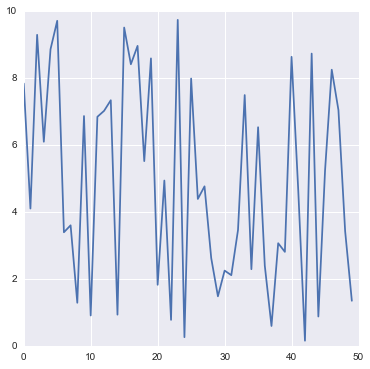

In [22]:
kwargs = {
    'npts': 50
}
html = lyzer.call_submit_function('graph_it', **kwargs);
with file('test.html', 'w') as fp:
    fp.write(html)

# Details on classes used

### InputElement and InputElementCollection

In [8]:
from ut.wserv.dashboard.analyzer import InputElement, InputElementCollection

In [9]:
element_1 = InputElement(name='my_element', type='number', display="Enter Number")

A InputElement is a dict (but it forces you to have a name and type keys. If the display key isn't given, it is set to the name.

In [10]:
print element_1['name']
print element_1['display']

my_element
Enter Number


A InputElementCollection is what it says it is: More precisely, it's a collections.OrderedDict collection indexed by the name of the list of InputElements we pass in

In [21]:
element_1 = dict(name='my_element', type='number', display="Enter Number: ", value=2)
element_2 = dict(name='my_other_element', type='text', value='some text')  # note there's no display here
element_3 = dict(name='do_something', type='submit', display="Do something: ", value="GO!")
input_element_collection = InputElementCollection([element_1, element_2, element_3])

In [22]:
print input_element_collection.keys()
print [v['display'] for k, v in input_element_collection.iteritems()]

['my_element', 'my_other_element', 'do_something']
['Enter Number: ', 'my_other_element', 'Do something: ']


In [23]:
input_element_collection['do_something']

{'display': 'Do something: ',
 'name': 'do_something',
 'type': 'submit',
 'value': 'GO!'}

In [24]:
from IPython.display import HTML
HTML(input_element_collection.to_html())

### Analyzer

In [26]:
from ut.wserv.dashboard.analyzer import Analyzer

In [28]:
element_1 = dict(name='my_element', type='number', display="Enter Number: ", value=2)
element_2 = dict(name='my_other_element', type='text', value='some text')  # note there's no display here
element_3 = dict(name='do_something', type='submit', display="Do something: ", value="GO!")
lyzer = Analyzer([element_1, element_2, element_3])

In [29]:
lyzer.__dict__.keys()

['input_element_collection', 'input', 'submit_methods']

In [32]:
print(lyzer.input['my_element'])
print(lyzer.input['my_other_element'])

2
some text


#### You can get the html of the form

In [33]:
print(lyzer.to_html())

<form>
Enter Number: <input type="number" name="my_element" value="2">
<br>
my_other_element<input type="text" name="my_other_element" value="some text">
<br>
Do something: <input type="submit" name="do_something" value="GO!">
<br>
</form>



In [34]:
from IPython.display import HTML
HTML(lyzer.to_html())

# SCRAP

# Getting the data

## In a single swoop

In [3]:
def get_data_for_two_tokens(token_1, token_2, mgcol='salmund_5s_fv', mgdb='sound'):
    mgc = MongoClient()[mgdb][mgcol]
    
    d = pd.DataFrame([x['fv'] for x in mgc.find({'tokens': token_1}, fields=['fv'])])
    d['token'] = token_1
    dd = pd.DataFrame([x['fv'] for x in mgc.find({'tokens': token_2}, fields=['fv'])])
    dd['token'] = token_2
    ddd = pd.concat([d,dd])
    
    diag = ut.daf.diagnosis.diag_df(ddd)
    print("row/cols before: {}".format(shape(ddd)))
    tokens = ddd['token']
    ddd = ddd[diag[diag['num_uniques'] > 1]['column']]
    ddd = ddd[array([c for c in ddd.columns if ddd[c].dtype == dtype('float64')])]
    ddd['token'] = tokens
    # ddd = pd.concat([ddd[['token']], t])
    print("row/cols after: {}".format(shape(ddd)))
    
    print("before dropping Nans: {} items".format(len(ddd)))
    t = ddd.dropna()
    print("after dropping Nans: {} items".format(len(t)))
    for tok in unique(t['token']):
        print("num of {}: {}".format(tok, sum(t['token'] == tok)))
        
    return t

## Choose tokens

In [10]:
data = get_data_for_two_tokens('car', 'bird')

row/cols before: (1839, 90)
row/cols after: (1839, 80)
before dropping Nans: 1839 items
after dropping Nans: 1427 items
num of bird: 266
num of car: 1161


In [11]:
data.head()

,intensity_absoluteAverageChange,intensity_autocorrelation,intensity_cumulatedDurationRatio,intensity_entropy,intensity_hasRhythm1,intensity_hasRhythm2,intensity_hasRhythm3,intensity_kurtosis,intensity_maxIntensity,intensity_percentile1,...,spectrum_relativeSpectralEnergy3,spectrum_relativeSpectralEnergy4,spectrum_skewness,spectrum_spectralKey1,spectrum_spectralKey2,spectrum_spectralKey3,spectrum_spectralKey4,spectrum_spectralKey5,spectrum_spread,token
0,2.384646,0.218786,646.258503,2.911078,0.148483,0.107815,0.028881,1.755605,114.907370,0.000000,...,0.627896,0.383561,-1.096029,474,1378,913,2301,2755,2079.1240,car
1,4.899240,0.384360,1496.598639,2.923385,0.355450,0.133765,0.041651,1.664164,192.265884,0.000000,...,0.337100,0.332259,-1.050670,2999,2646,3403,913,5254,2818.1096,car
2,0.985262,0.304535,272.108844,2.078504,0.255669,0.170465,0.000000,1.355787,42.043085,0.000000,...,0.107580,0.107352,-1.066443,1206,5938,8330,7115,9506,2475.0790,car
3,6.056200,0.181511,1224.489796,3.979721,0.101889,0.097493,0.093783,1.644759,76.411776,0.039668,...,0.577119,0.548071,-1.132519,53,4366,11133,1410,18121,2011.0571,car
4,1.511870,0.293385,1780.045351,3.593925,0.241732,0.063823,0.062031,1.801771,38.071173,0.004869,...,0.337987,0.177330,-1.062142,1139,2785,1677,2225,3011,2547.3281,car


## Choose Features

### A list to choose from

In [9]:
full_fv_list = list(data.columns)
print("total number of features: {}".format(len(full_fv_list)))
full_fv_list

total number of features: 80


[u'intensity_absoluteAverageChange',
 u'intensity_autocorrelation',
 u'intensity_cumulatedDurationRatio',
 u'intensity_entropy',
 u'intensity_hasRhythm1',
 u'intensity_hasRhythm2',
 u'intensity_hasRhythm3',
 u'intensity_kurtosis',
 u'intensity_maxIntensity',
 u'intensity_percentile1',
 u'intensity_percentile10',
 u'intensity_percentile20',
 u'intensity_percentile30',
 u'intensity_percentile40',
 u'intensity_percentile50',
 u'intensity_percentile60',
 u'intensity_percentile70',
 u'intensity_percentile80',
 u'intensity_percentile90',
 u'intensity_percentile99',
 u'intensity_powerRatioPeak1Peak2',
 u'intensity_powerRatioPeak2Peak3',
 u'intensity_powerRatioPeak3Peak4',
 u'intensity_powerRatioPeak4Peak5',
 u'intensity_relativeAverageChange',
 u'intensity_rhythm1',
 u'intensity_rhythm2',
 u'intensity_rhythm3',
 u'intensity_skewness',
 u'intensity_spread',
 u'intensity_temporalCentroid',
 u'intensity_timeDifferencePeak1Peak2',
 u'intensity_timeDifferencePeak2Peak3',
 u'intensity_timeDifferenc

### Select the features to analyze

In [12]:
fv_list = ['intensity_percentile10', 'intensity_powerRatioPeak1Peak2',
       'intensity_temporalCentroid', 'spectrum_isHarmonic',
       'spectrum_percentile50']

### Generate Graph

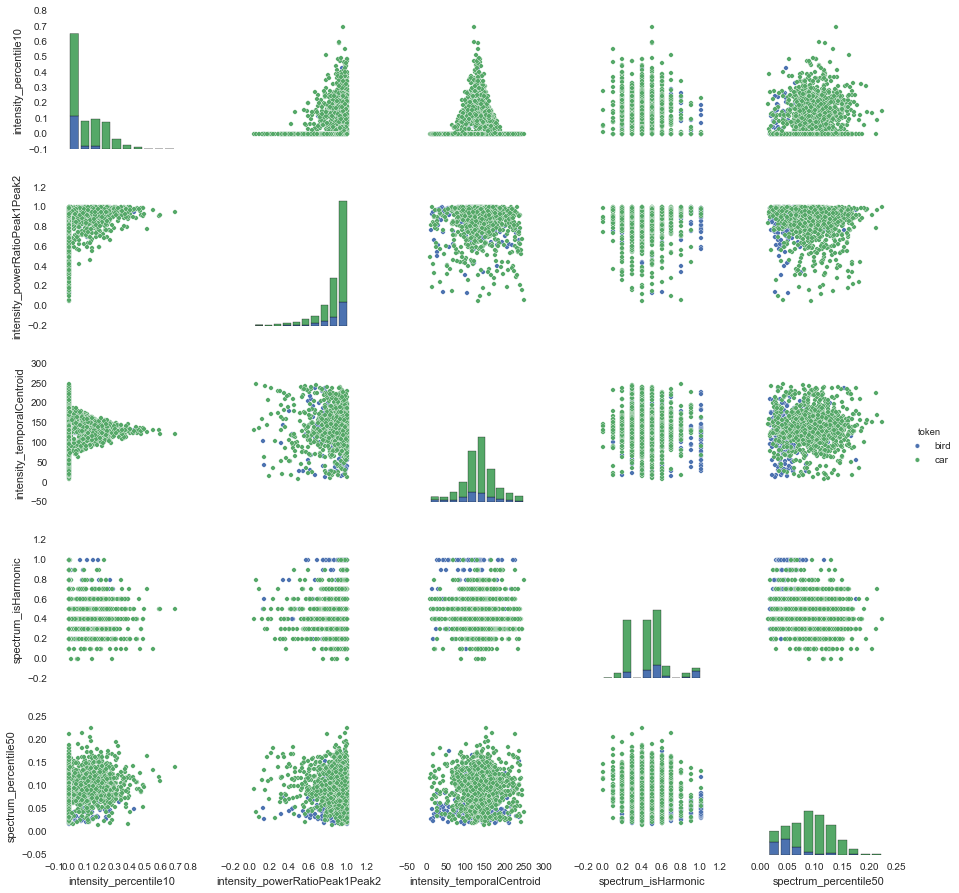

In [13]:
sns.pairplot(data[fv_list + ['token']], hue="token", size=2.5)

row/cols before: (1839, 90)
row/cols after: (1839, 80)
before dropping Nans: 1839 items
after dropping Nans: 1427 items
num of bird: 266
num of car: 1161


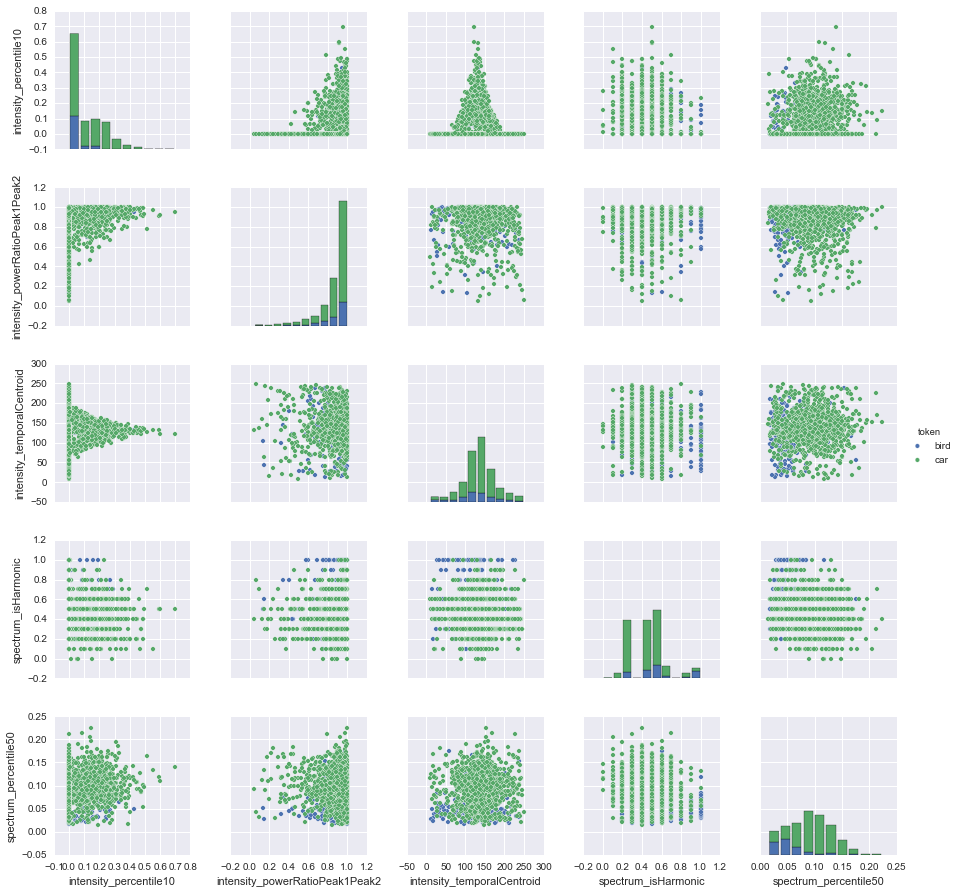

In [4]:
data = get_data_for_two_tokens('car', 'bird')
fv_list = ['intensity_percentile10', 'intensity_powerRatioPeak1Peak2',
       'intensity_temporalCentroid', 'spectrum_isHarmonic',
       'spectrum_percentile50']
sns.pairplot(data[fv_list + ['token']], hue="token", size=2.5)

In [14]:
from IPython.display import HTML

input_form = """
<div style="background-color:gainsboro; border:solid black; width:300px; padding:20px;">
Token 1: <input type="text" id="var_name" value="car"><br>
Token 2: <input type="text" id="var_value" value="bird"><br>
<button onclick="set_value()">Run Analysis</button>
</div>
"""

javascript = """
<script type="text/Javascript">
    function set_value(){
        var token1 = document.getElementById('var_name').value;
        var token2 = document.getElementById('var_value').value;
        var command = "data = get_data_for_two_tokens('" + token1 + "', '" + token2 +"')";
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        kernel.execute("sns.pairplot(data[fv_list + ['token']], hue='token', size=2.5)");
        
    }
</script>
"""

HTML(input_form + javascript)

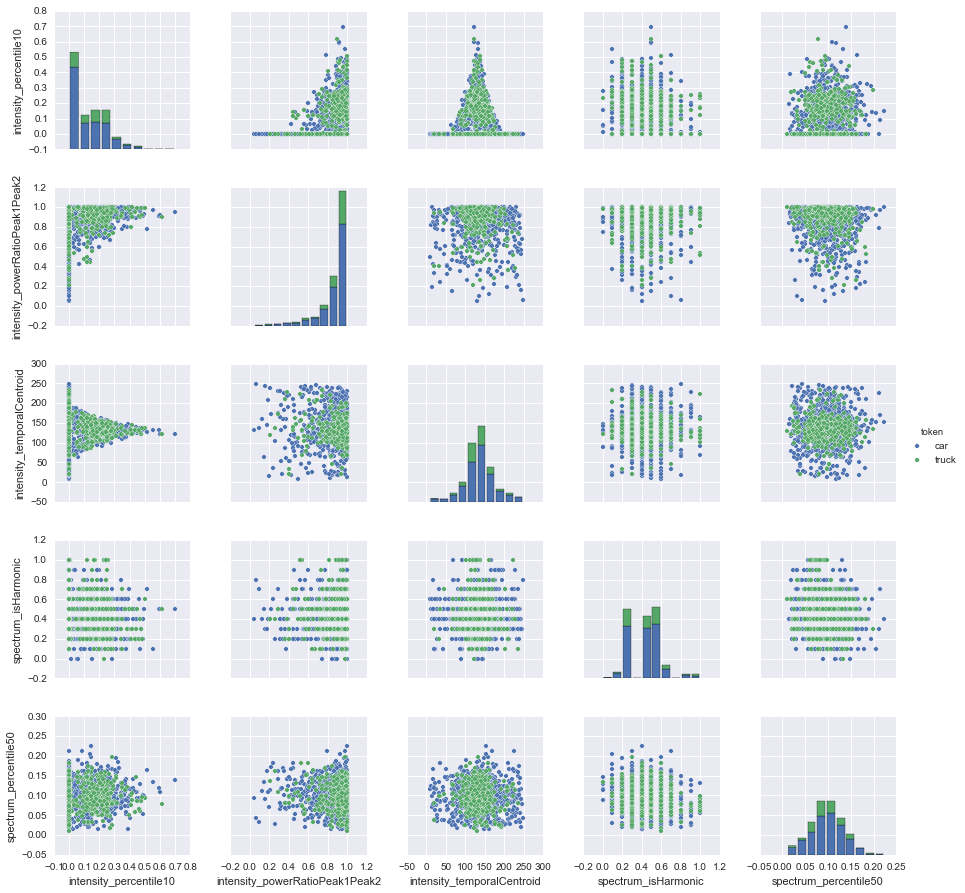

In [16]:
sns.pairplot(data[fv_list + ['token']], hue='token', size=2.5)

# Notes

#### Html input types

See http://www.w3schools.com/tags/tag_input.asp

button <br>
checkbox <br>
color <br>
date  <br>
datetime  <br>
datetime-local  <br>
email  <br>
file <br>
hidden <br>
image <br>
month  <br>
number  <br>
password <br>
radio <br>
range  <br>
reset <br>
search <br>
submit <br>
tel <br>
text <br>
time  <br>
url <br>
week <br>

<ul>
	<li><a href="/jsref/dom_obj_button.asp">Input Button Object</a></li>
	<li><a href="/jsref/dom_obj_checkbox.asp">Input Checkbox Object</a></li>
	<li><a href="/jsref/dom_obj_color.asp">Input Color Object</a></li>
	<li><a href="/jsref/dom_obj_date.asp">Input Date Object</a></li>
	<li><a href="/jsref/dom_obj_datetime.asp">Input Datetime Object</a></li>
	<li><a href="/jsref/dom_obj_datetime-local.asp">Input DatetimeLocal Object</a></li>
	<li><a href="/jsref/dom_obj_email.asp">Input Email Object</a></li>
	<li><a href="/jsref/dom_obj_fileupload.asp">Input FileUpload Object</a></li>
	<li><a href="/jsref/dom_obj_hidden.asp">Input Hidden Object</a></li>
	<li><a href="/jsref/dom_obj_input_image.asp">Input Image Object</a></li>
	<li><a href="/jsref/dom_obj_month.asp">Input Month Object</a></li>
	<li><a href="/jsref/dom_obj_number.asp">Input Number Object</a></li>
	<li><a href="/jsref/dom_obj_password.asp">Input Password Object</a></li>
	<li><a href="/jsref/dom_obj_range.asp">Input Range Object</a></li>
	<li><a href="/jsref/dom_obj_radio.asp">Input Radio Object</a></li>
	<li><a href="/jsref/dom_obj_reset.asp">Input Reset Object</a></li>
	<li><a href="/jsref/dom_obj_search.asp">Input Search Object</a></li>
	<li><a href="/jsref/dom_obj_submit.asp">Input Submit Object</a></li>
	<li><a href="/jsref/dom_obj_text.asp">Input Text Object</a></li>
	<li><a href="/jsref/dom_obj_input_time.asp">Input Time Object</a></li>
	<li><a href="/jsref/dom_obj_url.asp">Input URL Object</a></li>
	<li><a href="/jsref/dom_obj_week.asp">Input Week Object</a></li>
</ul>

In [2]:
from IPython.display import HTML

input_form = """
<div style="background-color:gainsboro; border:solid black; width:300px; padding:20px;">
Variable Name: <input type="text" id="var_name" value="foo"><br>
Variable Value: <input type="text" id="var_value" value="bar"><br>
<button onclick="set_value()">Set Value</button>
</div>
"""

javascript = """
<script type="text/Javascript">
    function set_value(){
        var var_name = document.getElementById('var_name').value;
        var var_value = document.getElementById('var_value').value;
        var command = var_name + " = '" + var_value + "'";
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
    }
</script>
"""

HTML(input_form + javascript)

In [4]:
tt

'40.3'